In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("..") 
from src import load_realized_vol, build_har_features,load_earnings,load_implied_vol  # etc.
from src.features import fit_har_regression
from src.signals import compute_signal_matrix
from src.forecast import create_forecast
from src.signals import size_positions


import pandas as pd
import pandas_market_calendars as mcal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np



In [1]:
config = {
    "har_windows": {"short": 1, "medium": 5, "long": 21},
    "forecast_horizon": 5,
    "ranking_threshold": 0.9,
    "train_test_split_ratio": 0.7,
    "train_test_gap_days": 21,
}

In [281]:
def filter_earnings(earnings, min_date, max_date):
    """Filter earnings data to only include dates within the range of realized volatility."""
    return earnings[(earnings['date'] >= min_date) & (earnings['date'] <= max_date)]


def filter_earnings_by_ticker(earnings, tickers):
    """Filter earnings data to only include specified tickers."""
    return earnings[earnings['act_symbol'].isin(tickers)]


def create_earnings_mask(realized, earnings_subset):
    """Create a mask for earnings dates in the realized volatility DataFrame."""
    # Initialize mask with False
    earnings_mask = pd.DataFrame(False, index=realized.index, columns=realized.columns)
    
    # Set True on earnings days
    for idx, row in earnings_subset.iterrows():
        date, ticker = row['date'], row['act_symbol']
        if date in earnings_mask.index and ticker in earnings_mask.columns:
            earnings_mask.at[date, ticker] = True
            
    return earnings_mask

In [282]:
realized = load_realized_vol()
earnings = load_earnings()
earnings_subset = filter_earnings(earnings, min_date, max_date)
earnings_subset = filter_earnings_by_ticker(earnings_subset, realized.columns)
earnings_mask = create_earnings_mask(realized, earnings_subset)

min_date,max_date = realized.index.min(), realized.index.max()

implied = load_implied_vol("../output/features_data.csv", earnings_subset)


KeyboardInterrupt: 

In [ ]:
har_1d, har_1w, har_1m = build_har_features(realized)


har_factors = fit_har_regression(realized, har_1d.shift(1), har_1w.shift(1), har_1m.shift(1), earnings_mask=earnings_mask)
forecast = create_forecast(har_1d, har_1w, har_1m, har_factors)
signal_matrix = compute_signal_matrix(forecast, implied) #both forecast and implied are as of today
positions = size_positions(signal_matrix, implied.loc[forecast.index], method='unit', threshold=0.0)


In [ ]:
realized_adjusted = realized.copy()
realized_adjusted[earnings_mask] = forecast[earnings_mask]

har_1d, har_1w, har_1m = build_har_features(realized_adjusted)
forecast = create_forecast(har_1d, har_1w, har_1m, har_factors)
signal_matrix = compute_signal_matrix(forecast, implied) #both forecast and implied are as of today
positions = size_positions(signal_matrix, implied.loc[forecast.index], method='unit', threshold=0.0)

In [248]:
aligned_realized, aligned_implied = realized.shift(-1).align(implied.shift(0), join='inner', axis=None)
aligned_realized_temp, aligned_signal=aligned_realized.shift(0).align(signal_matrix.shift(0),  axis=None)
aligned_realized_temp, aligned_positions = realized.shift(-1).align(positions.shift(0), join='inner', axis=None)




In [ ]:
signal_matrix

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-08,0.010242,NaN,NaN,0.112631,NaN,NaN,0.037706,NaN,0.045943,0.122558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.046970,0.014160,0.043598,0.060370,0.079356,NaN,0.058489,0.079675,0.081465,0.093537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,0.015854,-0.057754,-0.033882,0.016594,0.040757,NaN,0.024993,0.034852,0.040678,0.041119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-27,0.019148,-0.056962,-0.018798,0.025917,0.049290,NaN,0.015758,0.038187,0.045173,0.028201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [317]:
#def align_multiple(*dfs):
#    idx = dfs[0].index
#    for df in dfs[1:]:
#        idx = idx.intersection(df.index)
#    return [df.loc[idx] for df in dfs]

def align_multiple(*dfs, align_columns=False):
    # Intersect indices (rows/dates) explicitly
    common_idx = dfs[0].index
    for df in dfs[1:]:
        common_idx = common_idx.intersection(df.index)

    if align_columns:
        # Optional column alignment
        common_cols = dfs[0].columns
        for df in dfs[1:]:
            common_cols = common_cols.intersection(df.columns)
        return [df.loc[common_idx, common_cols] for df in dfs]
    else:
        # Only align rows
        return [df.loc[common_idx] for df in dfs]


# Usage:
#aligned_realized, aligned_implied,aligned_forecast, aligned_signal,aligned_positions= align_multiple(realized.shift(1), implied, forecast, signal_matrix, positions, align_columns=True)
aligned_realized, aligned_implied,aligned_forecast, aligned_signal,aligned_positions= align_multiple(df_future_close_realized_vol, implied, forecast, signal_matrix, positions, align_columns=True)


#aligned_realized, aligned_implied,aligned_forecast, aligned_signal,aligned_positions= align_multiple(realized.shift(1), implied, forecast, signal_matrix, positions)

In [318]:
X = aligned_signal.stack().rename("signal")
y=(aligned_realized>aligned_implied).stack().astype(int)
aligned_x, aligned_y = X.align(y, join='inner', axis=0)

In [319]:
X = aligned_signal.stack().rename("signal")
#y = (aligned_realized.loc[forecast.index]>aligned_implied.loc[forecast.index]).stack().astype(int).reset_index(drop=True)
y = (aligned_realized > aligned_implied).stack().astype(int)
y = (aligned_realized - aligned_implied).stack()
# Intersection of multi-indices
common_idx = X.index.intersection(y.index)

X_aligned = X.loc[common_idx]
y_aligned = y.loc[common_idx]

# Ready for modeling
X_df = X_aligned.reset_index(drop=True).to_frame()
y_series = y_aligned.reset_index(drop=True)

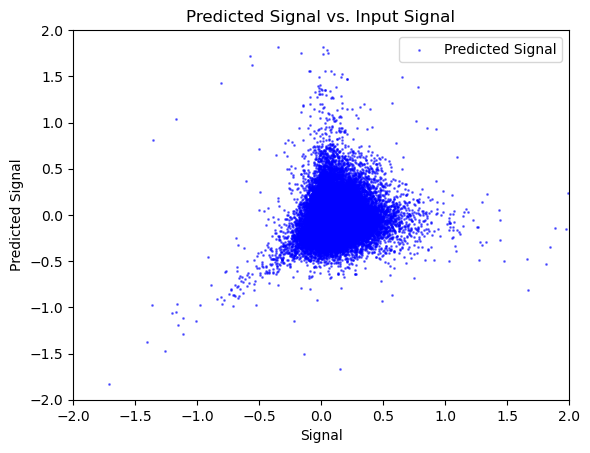

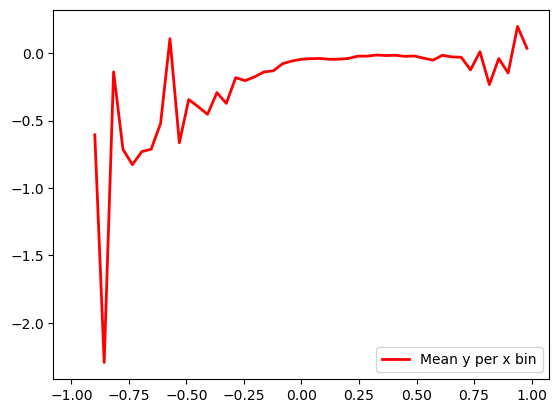

In [320]:


plt.scatter(X_df['signal'], y_series, label='Predicted Signal', color='blue', alpha=0.5,s=1)
plt.title('Predicted Signal vs. Input Signal')
plt.xlabel('Signal')
plt.ylabel('Predicted Signal')
plt.legend()
#set x and y limits
plt.xlim(-2,2)
plt.ylim(-2, 2)
plt.show()
# Bin the x values and compute mean y for each bin
bins = np.linspace(-1, 1, 50)
digitized = np.digitize(X_df['signal'], bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
mean_y = [y_series[digitized == i].mean() for i in range(1, len(bins))]

plt.plot(bin_centers, mean_y, color='red', label='Mean y per x bin', linewidth=2)
plt.legend()

In [321]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#clf = RandomForestClassifier(max_depth=3).fit(X_df, y_series)
clf= RandomForestRegressor(max_depth=3).fit(X_df, y_series)

print("Accuracy:", clf.score(X_df, y_series))
print("Feature Importance:", clf.feature_importances_)

y_prediction = clf.predict(X_df)
# Clearly calculate evaluation metrics
print("Train Metrics:")
print("  RMSE:", mean_squared_error(X_df, y_prediction))
print("  MAE:", mean_absolute_error(X_df, y_prediction))
print("  R²:", r2_score(X_df, y_prediction))


Accuracy: 0.027776305102330978
Feature Importance: [1.]
Train Metrics:
  RMSE: 0.030926428699072247
  MAE: 0.12888294073796494
  R²: -1.0636408855992836


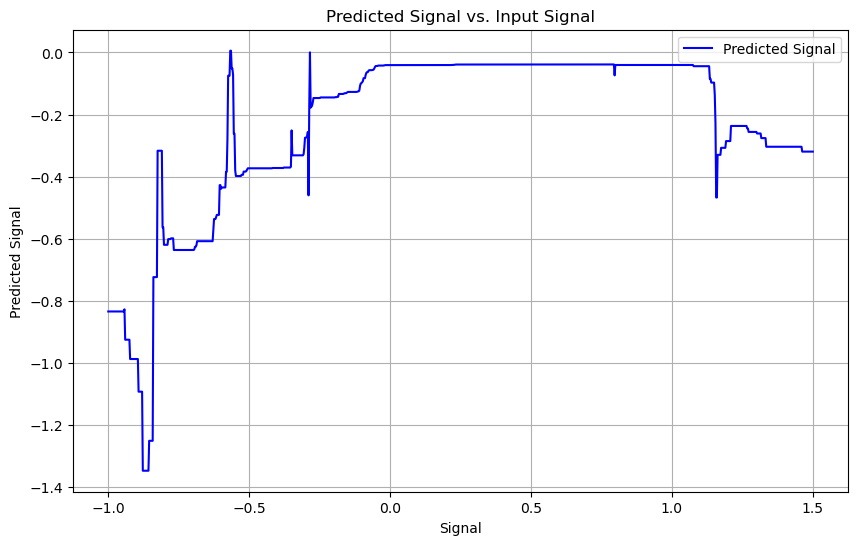

In [322]:
X_example = pd.DataFrame({
    'signal': np.linspace(-1, 1.5, 1000)
})
y_prediction = clf.predict(X_example)
#y_proba = clf.predict_proba(X_example)[:, 1]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(X_example['signal'], y_prediction, label='Predicted Signal', color='blue')
plt.title('Predicted Signal vs. Input Signal')
plt.xlabel('Signal')
plt.ylabel('Predicted Signal')
plt.legend()
plt.grid()
plt.show()

In [311]:
# Assume your aligned data (signal_matrix, realized, implied) is indexed by (date, ticker)
unique_dates = signal_matrix.index.get_level_values(0).unique().sort_values()

split_ratio = 0.7  # 70% train, 30% test
split_point = int(len(unique_dates) * split_ratio)

train_dates = unique_dates[:split_point]
test_dates = unique_dates[split_point + 21:]  # explicit 21-day gap


In [312]:

# Splitting explicitly
X_train = X_aligned[X_aligned.index.get_level_values(0).isin(train_dates)].reset_index(drop=True).to_frame()
y_train = y_aligned[y_aligned.index.get_level_values(0).isin(train_dates)].reset_index(drop=True)

X_test = X_aligned[X_aligned.index.get_level_values(0).isin(test_dates)].reset_index(drop=True).to_frame()
y_test = y_aligned[y_aligned.index.get_level_values(0).isin(test_dates)].reset_index(drop=True)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"len y_train: {len(y_train)}, len y_test: {len(y_test)}")

Train samples: 107493, Test samples: 34820
len y_train: 107493, len y_test: 34820


In [277]:
type(X_train)

pandas.core.frame.DataFrame

Accuracy: 0.02268355904711783
Feature Importance: [1.]
Test accuracy: 0.03482705660015728


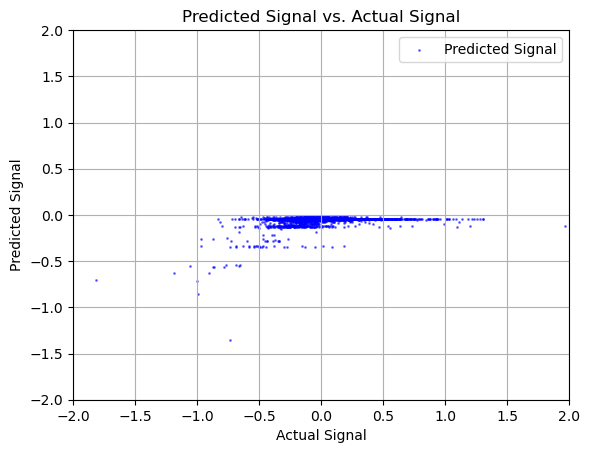

In [313]:
from sklearn.ensemble import RandomForestClassifier
#clf2 = RandomForestClassifier(max_depth=3).fit(X_train, y_train)
clf2= RandomForestRegressor(max_depth=3).fit(X_train, y_train)


print("Accuracy:", clf.score(X_train, y_train))
print("Feature Importance:", clf.feature_importances_)
#y_test_pred = clf2.predict(X_test)
#y_test_proba = clf2.predict_proba(X_test)[:, 1]

print("Test accuracy:", clf2.score(X_test, y_test))
y_test_pred = clf2.predict(X_test)

plt.scatter(y_test, y_test_pred, label='Predicted Signal', color='blue', alpha=0.5,s=1)
plt.title('Predicted Signal vs. Actual Signal')
plt.xlabel('Actual Signal')
plt.ylabel('Predicted Signal')
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()



In [273]:
X

            ticker
2023-01-04  A         0.043174
            AAL       0.008006
            AAP       0.086052
            AAPL      0.033322
            ABBV      0.037811
                        ...   
2023-12-20  SNA       0.107331
            SNPS      0.122860
            SO        0.106200
            SPG       0.111144
            SPGI      0.087985
Name: signal, Length: 73765, dtype: float64

In [314]:
#not used right now, read the daaily close to close implied vol (because the implied vol includes the close to open moves)
# so while the har variables are based purely on intraday data, the implied vol is based on the daily close to close

df = pd.read_csv("../data/all_vols.csv", parse_dates=["date"])
df_prices=df.pivot(index="date", columns="ticker", values="close")
df_returns= df_prices.pct_change()
df_close_realized_vol = (
    np.sqrt((df_returns ** 2).rolling(5, min_periods=5).mean()) * np.sqrt(252)
)
df_future_close_realized_vol = df_close_realized_vol.shift(-5)

/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_64123/4098351699.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns= df_prices.pct_change()


In [315]:

df_close_realized_vol

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.155927,0.270232,0.331558,0.104582,0.150966,0.0,0.120491,0.180756,0.240123,0.222465,...,0.360303,0.145773,0.170563,0.325182,0.199196,0.132900,0.089967,0.288648,0.357306,0.134879
2023-12-26,0.151569,0.262593,0.235548,0.095962,0.148649,0.0,0.107358,0.137610,0.236707,0.137490,...,0.360100,0.117071,0.155615,0.325894,0.208867,0.084635,0.103714,0.317873,0.360420,0.134128
2023-12-27,0.096775,0.267732,0.245962,0.088144,0.149120,0.0,0.111022,0.136183,0.236816,0.121097,...,0.305720,0.140288,0.128208,0.296001,0.205778,0.089316,0.080169,0.309412,0.332627,0.136240


In [316]:
df_future_close_realized_vol

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.325950,0.373263,0.222490,0.241137,0.097066,0.218731,0.172263,0.202458,0.396001,0.569933,...,0.329686,0.140282,0.333152,0.171649,0.149228,0.174705,0.124082,0.475043,0.375930,0.436621
2022-01-04,0.234825,0.369183,0.230300,0.253621,0.101569,0.228855,0.046740,0.187608,0.395458,0.557783,...,0.424164,0.184078,0.360179,0.202826,0.177026,0.226586,0.128507,0.474188,0.326263,0.341546
2022-01-05,0.246148,0.398443,0.284067,0.167259,0.094951,0.224243,0.110366,0.168369,0.376708,0.227993,...,0.335247,0.170010,0.349420,0.257376,0.151260,0.223768,0.199424,0.326841,0.325892,0.215895
2022-01-06,0.320989,0.507791,0.265190,0.180297,0.213440,0.200151,0.241239,0.168334,0.334136,0.308659,...,0.358337,0.166803,0.310954,0.276405,0.185155,0.213645,0.236055,0.359277,0.143856,0.289401
2022-01-07,0.260655,0.527645,0.249975,0.182720,0.246211,0.153712,0.254325,0.192659,0.344677,0.309048,...,0.708447,0.154872,0.328583,0.275419,0.249537,0.220813,0.235156,0.176322,0.101194,0.203079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


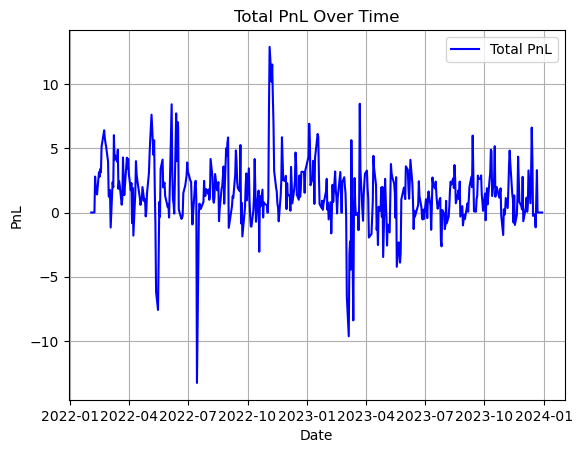

In [ ]:
signal_rank = aligned_signal.rank(axis=1, pct=True)
top = (signal_rank>=.9)
bottom = signal_rank<=.1
buy_pnl= aligned_realized[top==True]- aligned_implied[top==True]
bottom_pnl = aligned_realized[bottom] - aligned_implied[bottom]

total_pnl = buy_pnl.sum(axis=1) - bottom_pnl.sum(axis=1)
total_pnl
cumulative_pnl = total_pnl.cumsum()

plt.plot(total_pnl.index, total_pnl, label='Total PnL', color='blue')
#plt.plot(cumulative_pnl.index, cumulative_pnl, label='Cumulative PnL', color='orange')
plt.title('Total PnL Over Time')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()

In [ ]:
signal_

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE
2022-02-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-07,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-08,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
2023-12-26,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
2023-12-27,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
2023-12-28,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
